In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, classification_report)
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier




#Set constants
RANDOM_SEED = 1

In [2]:
# Data preprocessing

# Import data from csv file
data = pd.read_csv("../../machine_learning/siren_data_train.csv", sep=",")


# Calculate the distance to nearest horn

list_loc_horn = []
list_loc_person = []
list_distance_to_horn = []

x_cor_horn = data["near_x"]
y_cor_horn = data["near_y"]

x_cor_person = data["xcoor"]
y_cor_person = data["ycoor"]

for row in range(len(x_cor_horn)):
    loc_horn = [x_cor_horn[row], y_cor_horn[row]]
    list_loc_horn.append(loc_horn)

    loc_person = [x_cor_person[row], y_cor_person[row]]
    list_loc_person.append(loc_person)

for i in range(len(x_cor_horn)):
    
    coordinate_horn = list_loc_horn[i] 
    coordinate_person = list_loc_person[i]
    distance_to_horn = math.dist(coordinate_horn,coordinate_person)
    list_distance_to_horn.append(distance_to_horn)
   
data["distance to nearest horn"] = list_distance_to_horn

In [4]:

# Create X and y
#features = [ "near_fid", "near_x", "near_y", "near_angle", "building", "xcoor", "ycoor", "noise", "in_vehicle", "asleep", "no_windows", "age"]
features = ['building','noise','asleep','in_vehicle','no_windows','age','distance to nearest horn']
X = data[features]
y = data[["heard"]]

# Create training data and held-out test data
X_train, X_heldout, y_train, y_heldout = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, shuffle=True)



In [5]:
# Learn a decision tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

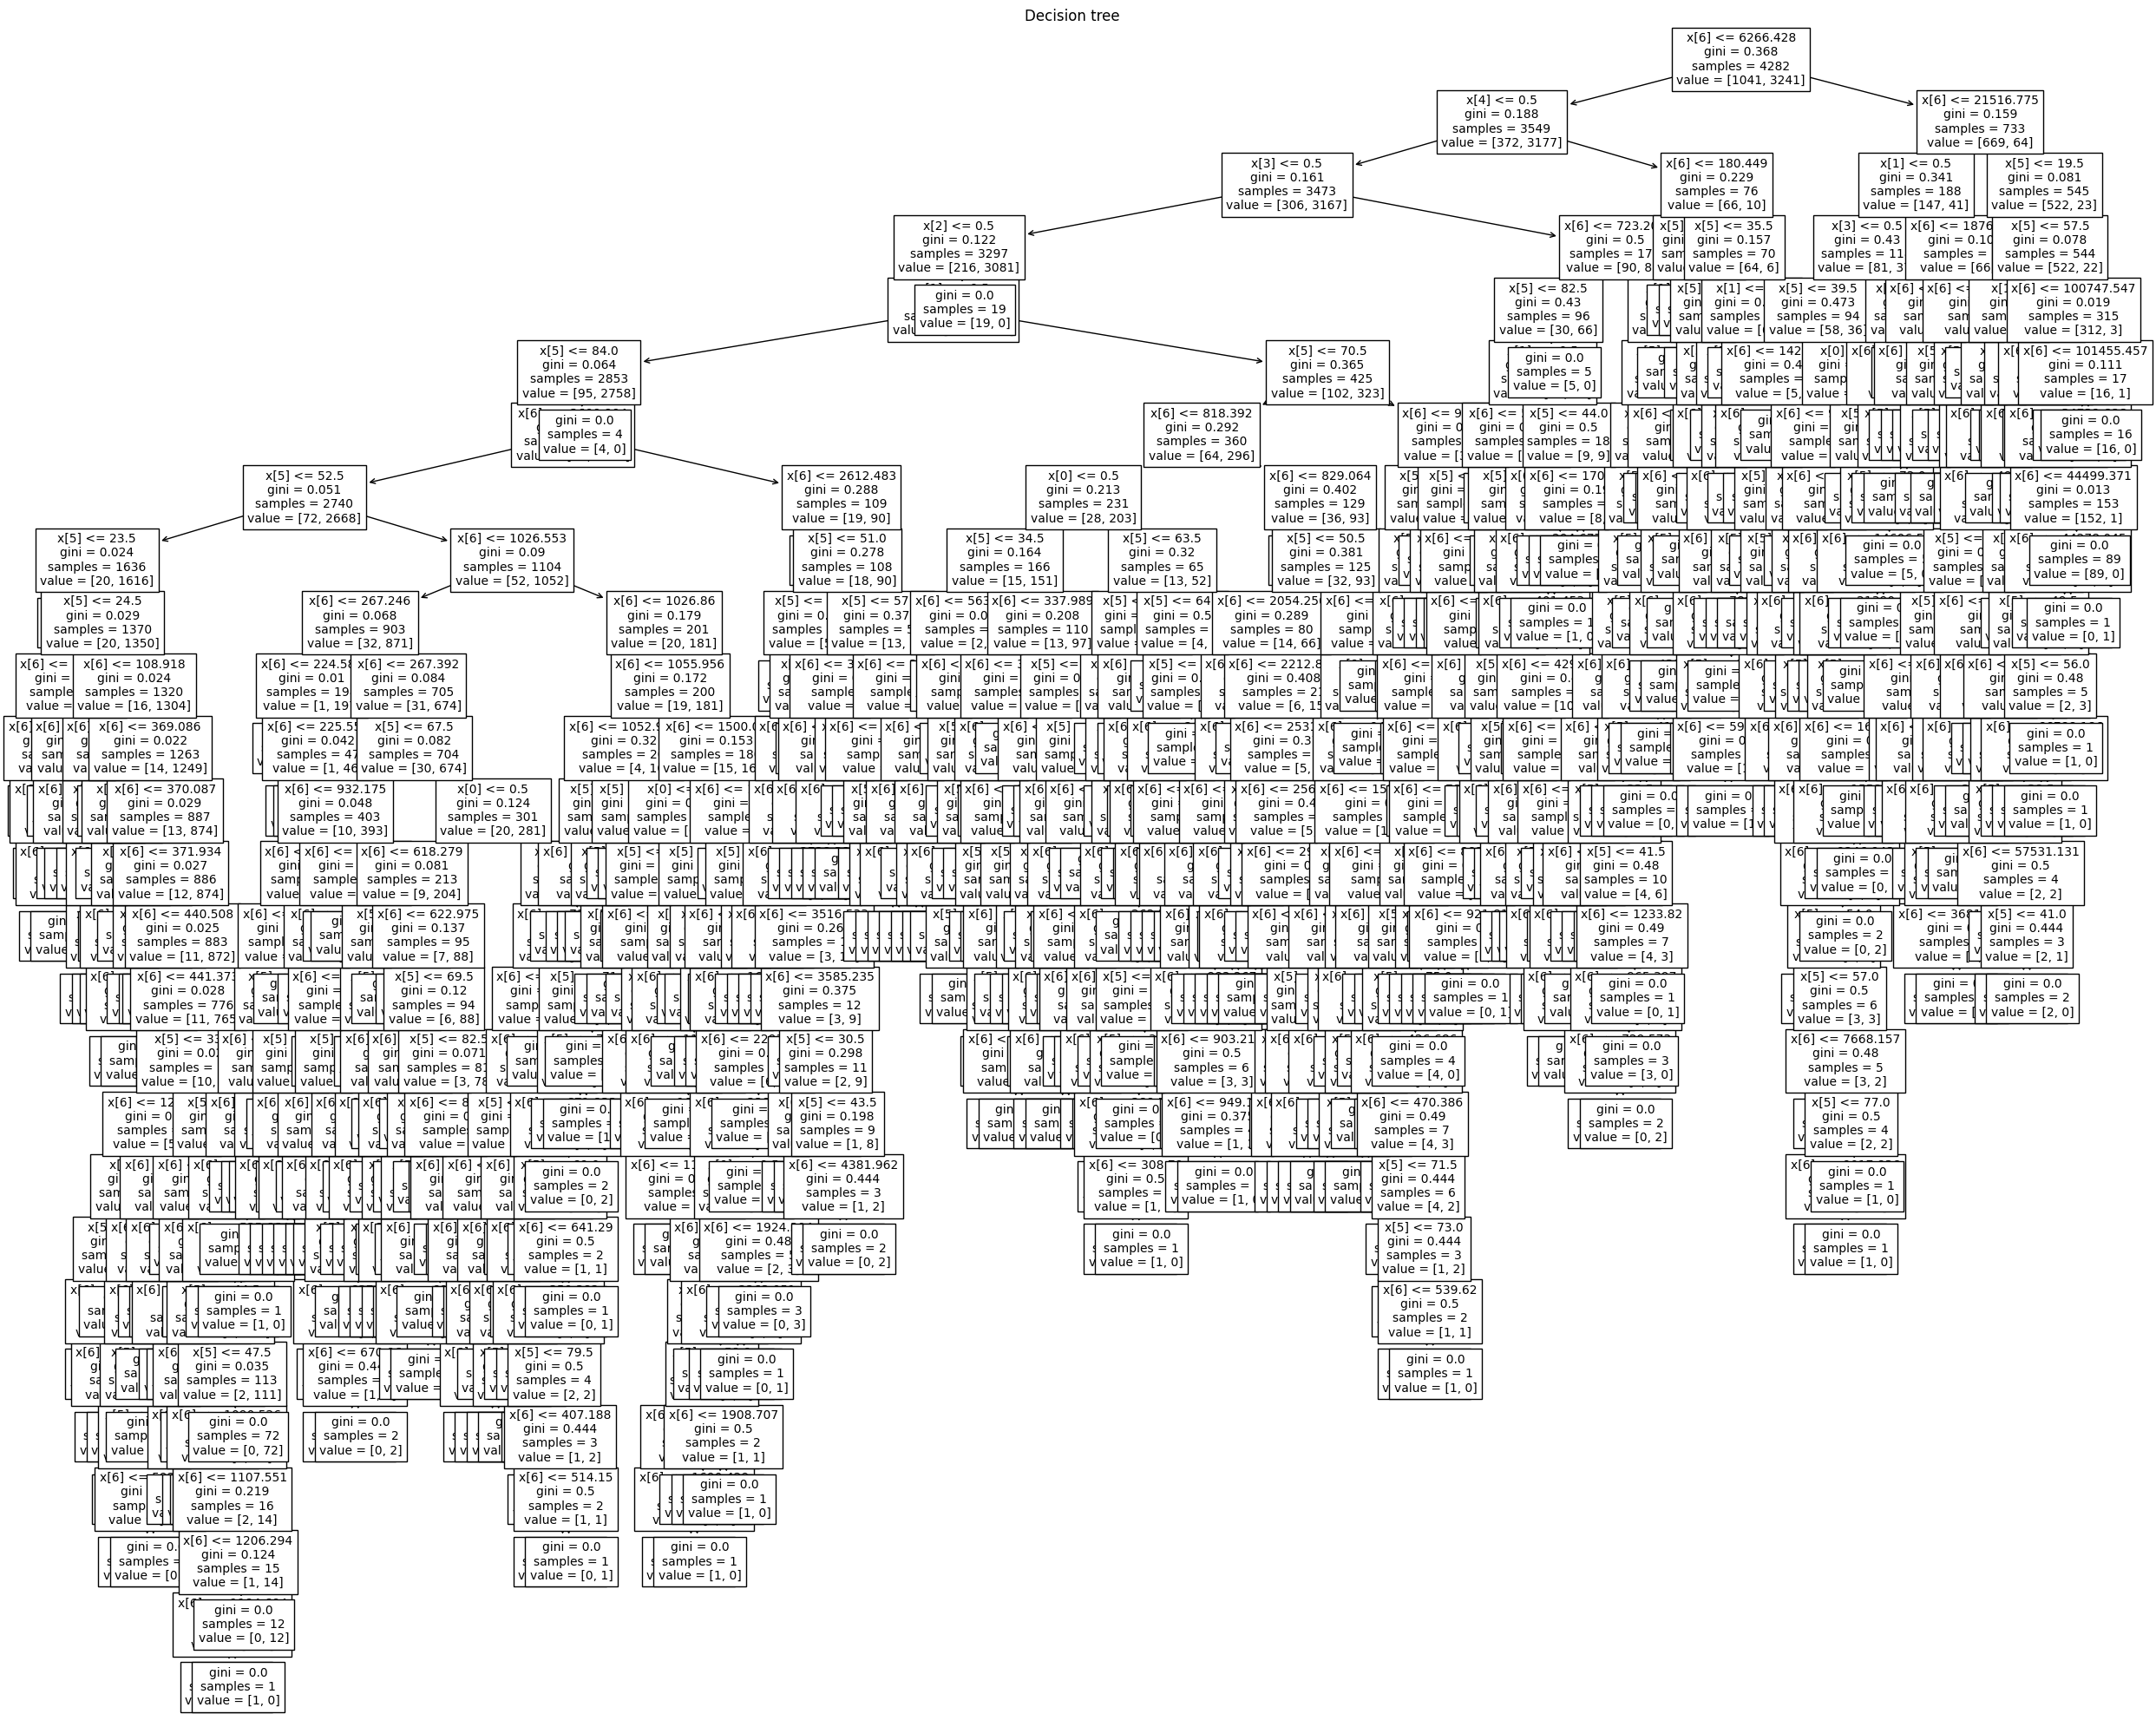

In [6]:
# Plot decision tree
def plot_tree_custom_size(classifier, figsize=(25, 20), fontsize=10):
    fig, ax = plt.subplots(figsize=figsize)
    plot_tree(classifier, fontsize=fontsize, ax=ax)
    ax.set_title("Decision tree")
    fig.tight_layout()

plot_tree_custom_size(decision_tree)

In [7]:
# Performance metrics
y_pred = decision_tree.predict(X_heldout)

def print_performance_metrics(y_true, y_pred):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred), "\n")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3}")
    print(f"Recall: {recall_score(y_true, y_pred):.2}")
    print(f"Precision: {precision_score(y_true, y_pred):.2}")
    print(f"F1: {f1_score(y_true, y_pred):.2}")

print_performance_metrics(y_heldout, y_pred)
print(classification_report(y_heldout, y_pred, digits= 3))

Confusion Matrix:
 [[ 253   76]
 [  86 1013]] 

Accuracy: 0.887
Recall: 0.92
Precision: 0.93
F1: 0.93
              precision    recall  f1-score   support

           0      0.746     0.769     0.757       329
           1      0.930     0.922     0.926      1099

    accuracy                          0.887      1428
   macro avg      0.838     0.845     0.842      1428
weighted avg      0.888     0.887     0.887      1428



              precision    recall  f1-score   support

           0      0.833     0.802     0.817       329
           1      0.941     0.952     0.947      1099

    accuracy                          0.917      1428
   macro avg      0.887     0.877     0.882      1428
weighted avg      0.916     0.917     0.917      1428



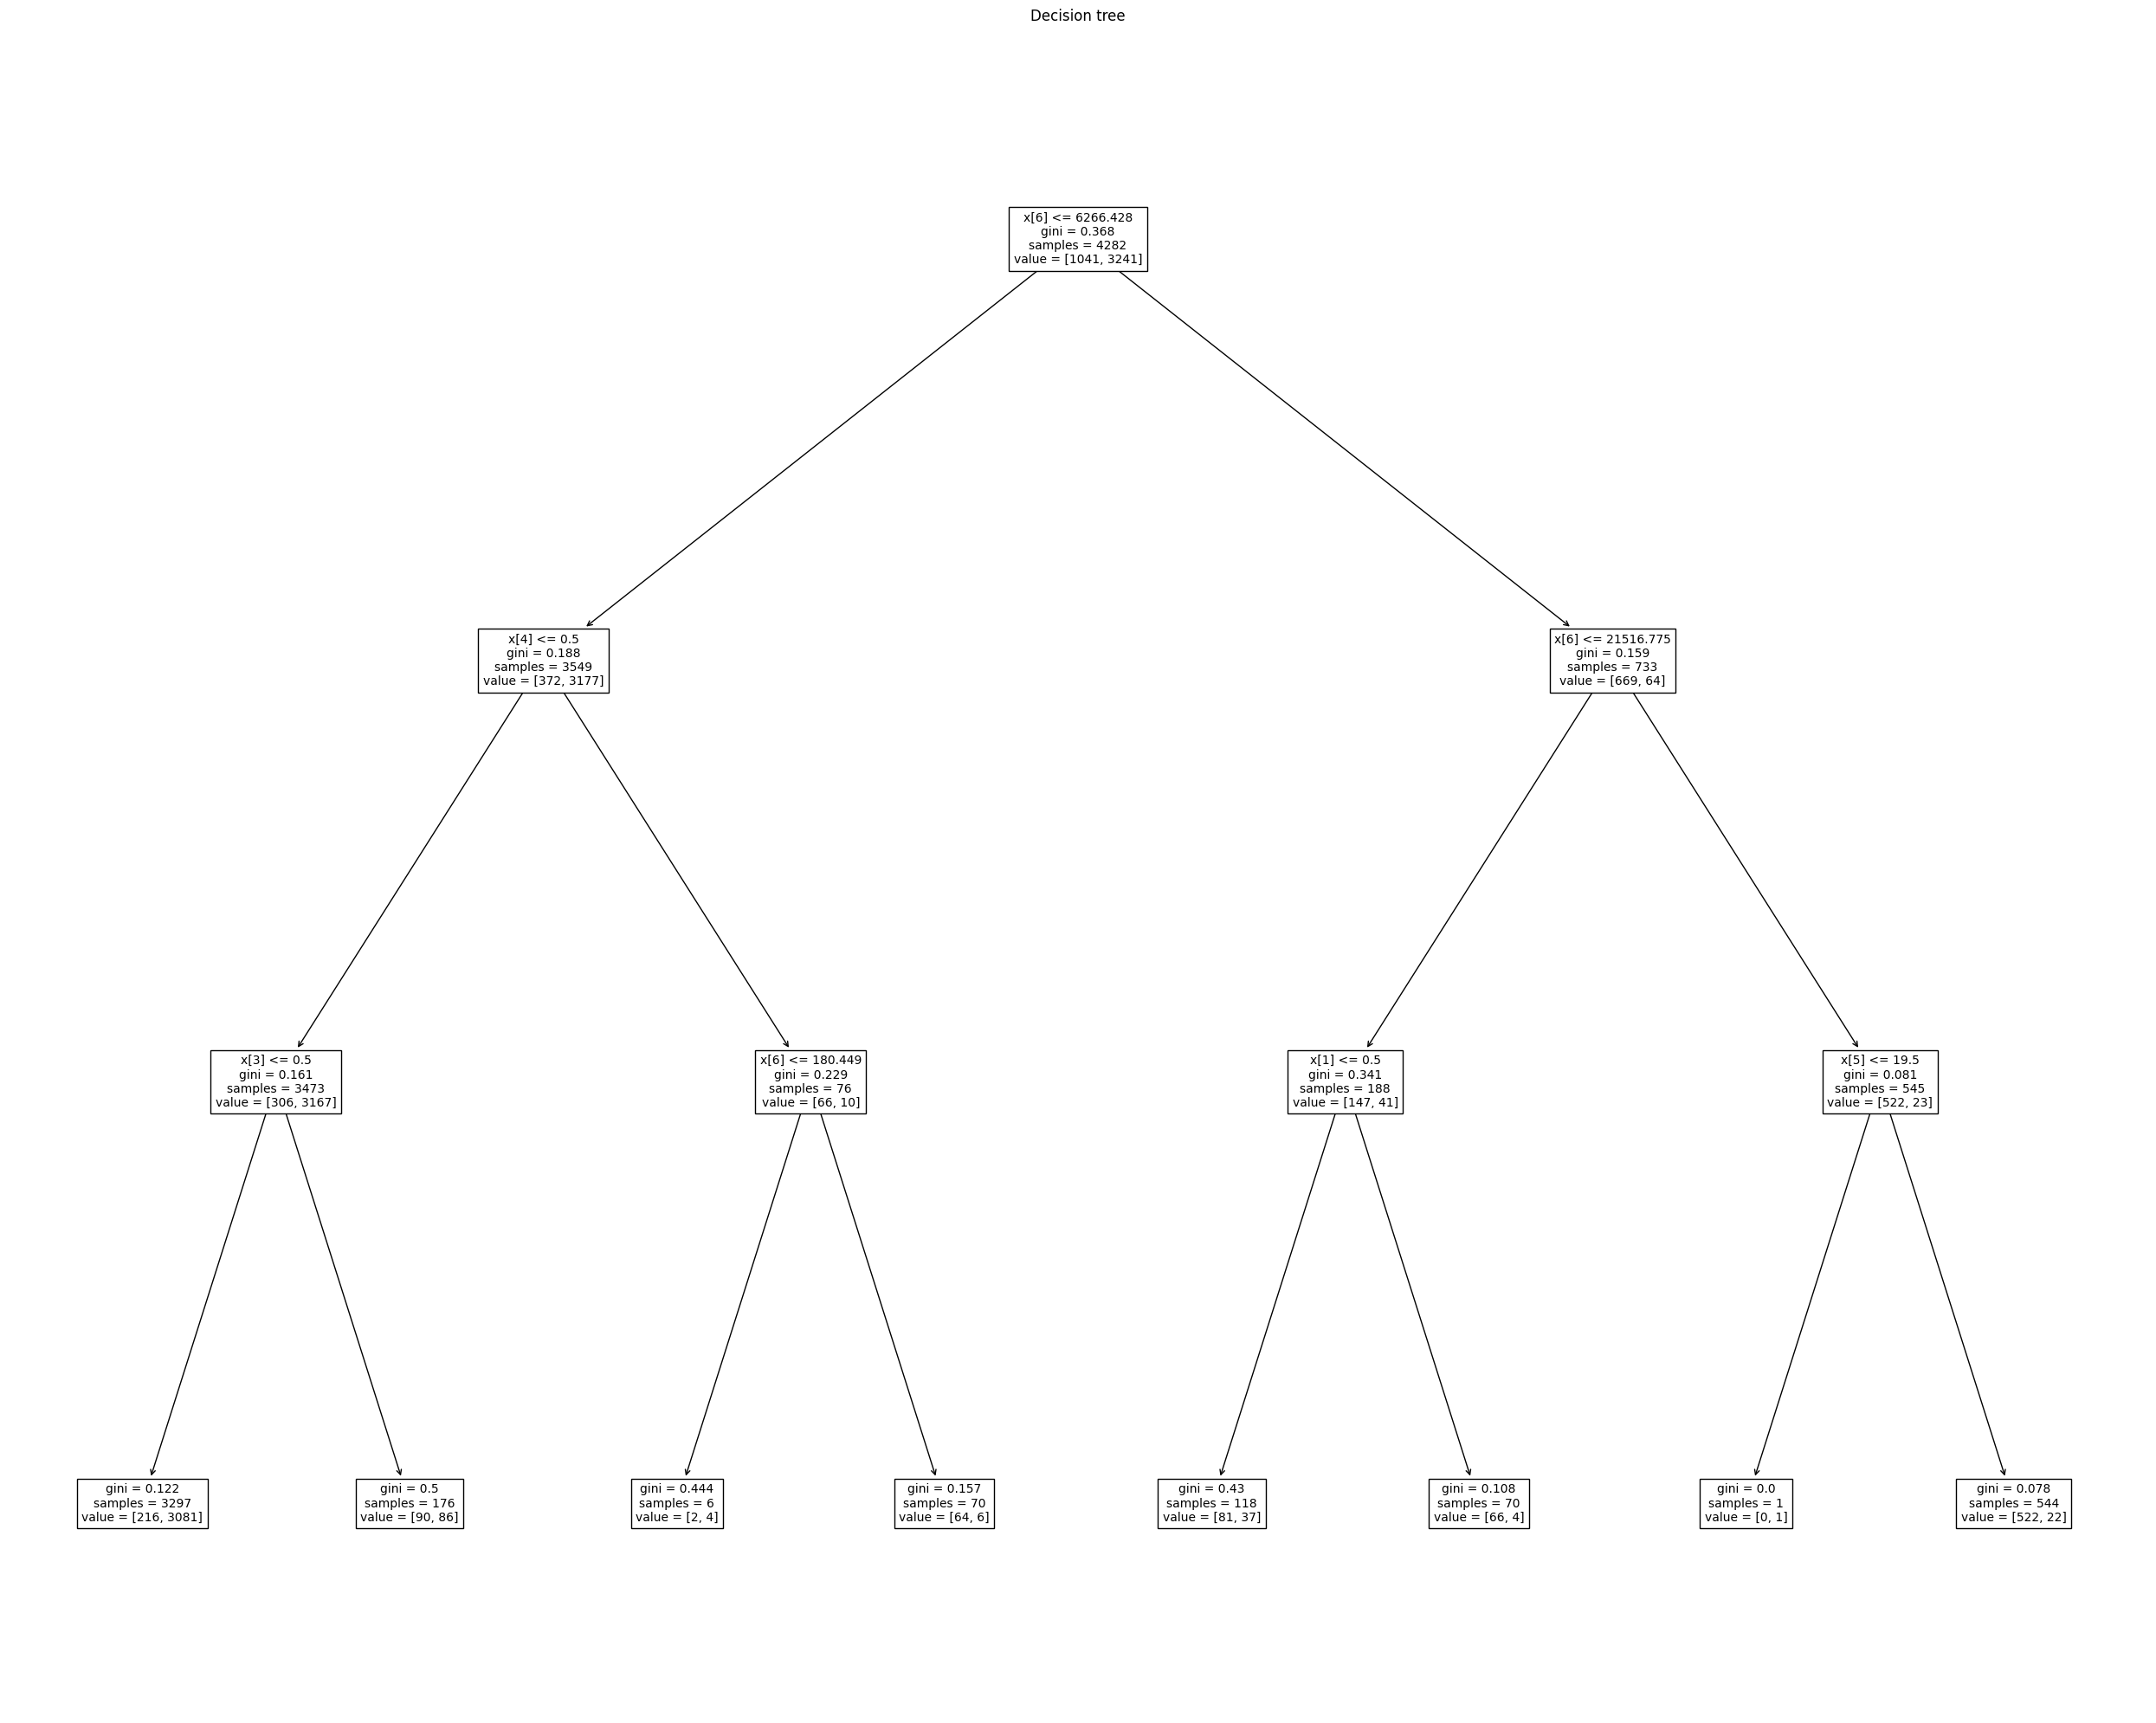

In [8]:
# Trying parameter value max_depth=3

decision_tree_max_dept_3 = tree.DecisionTreeClassifier(max_depth=3)
decision_tree_max_dept_3.fit(X_train, y_train)

y_pred = decision_tree_max_dept_3.predict(X_heldout)
#print_performance_metrics(y_heldout, y_pred)

plot_tree_custom_size(decision_tree_max_dept_3)
print(classification_report(y_heldout, y_pred, digits= 3))


In [9]:
from sklearn.model_selection import GridSearchCV

# Parameter tuning with grid search
model = tree.DecisionTreeClassifier()
params = {"max_depth":np.arange(2, 10),"min_samples_leaf":np.arange(1, 14) ** 2}
grid_search = GridSearchCV(model, params, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)
f1_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
best_lda_model = grid_search.best_estimator_
accuracy = best_lda_model.score(X_heldout, y_heldout)

#print_performance_metrics(y_heldout, y_pred)
print(classification_report(y_heldout, y_pred, digits= 3))


{'max_depth': 6, 'min_samples_leaf': 4}
              precision    recall  f1-score   support

           0      0.833     0.802     0.817       329
           1      0.941     0.952     0.947      1099

    accuracy                          0.917      1428
   macro avg      0.887     0.877     0.882      1428
weighted avg      0.916     0.917     0.917      1428



In [10]:
# Parameter tuning
# Choice of parameters: max_depth, min_samples_leaf
# Using 5-fold cross-validation in order to decide the optimal values of the parameters max_depth and min_samples_leaf.

# Create 5-fold cross-validation
nk = 5
kf = KFold(n_splits=nk, random_state=RANDOM_SEED, shuffle=True)

# Search space of the parameters
max_depth_choices = np.arange(2, 10)
min_samples_leaf_choices = np.arange(1, 14) ** 2

# Learn an optimal decision tree model

param_choices = [
    {"max_depth": max_depth, "min_samples_leaf": min_samples_leaf}
    for max_depth in max_depth_choices
    for min_samples_leaf in min_samples_leaf_choices
]

accuracy = np.zeros((nk, len(param_choices)))
f1 = np.zeros((nk, len(param_choices)))
recall = np.zeros((nk, len(param_choices)))
precision = np.zeros((nk, len(param_choices)))

for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    for j, param in enumerate(param_choices):
        dt = tree.DecisionTreeClassifier(
            max_depth=param["max_depth"], min_samples_leaf=param["min_samples_leaf"]
        )
        dt.fit(X_t, y_t)
        y_pred = dt.predict(X_val)
        accuracy[i][j] = accuracy_score(y_val, y_pred)
        f1[i][j] = f1_score(y_val, y_pred)
        recall[i][j] = recall_score(y_val, y_pred)
        precision[i][j] = precision_score(y_val, y_pred)

# Finding model with maximum F1 score
best_model = param_choices[np.argmax(np.mean(f1, axis=0))]
print("Selected model for F1:", best_model)

# Computing the performance of the best model 
dt = tree.DecisionTreeClassifier(**best_model)
dt.fit(X_t, y_t)
y_pred = dt.predict(X_heldout)
print_performance_metrics(y_heldout, y_pred)
print(classification_report(y_heldout, y_pred, digits= 3))
# max_depth = 5, min_samples_leaf = 9



Selected model for F1: {'max_depth': 5, 'min_samples_leaf': 9}
Confusion Matrix:
 [[ 256   73]
 [  40 1059]] 

Accuracy: 0.921
Recall: 0.96
Precision: 0.94
F1: 0.95
              precision    recall  f1-score   support

           0      0.865     0.778     0.819       329
           1      0.936     0.964     0.949      1099

    accuracy                          0.921      1428
   macro avg      0.900     0.871     0.884      1428
weighted avg      0.919     0.921     0.919      1428



In [11]:

print("Confusionmatrics Naive model")

only_heard = np.ones((y_heldout.shape[0]))

#print_performance_metrics(y_heldout, only_heard)
print(classification_report(y_heldout, only_heard, digits= 3))



Confusionmatrics Naive model
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       329
           1      0.770     1.000     0.870      1099

    accuracy                          0.770      1428
   macro avg      0.385     0.500     0.435      1428
weighted avg      0.592     0.770     0.669      1428



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [12]:
#Random forest - combines the simplicity of decision trees with flexibility resulting in a vast improvement in accuracy

rf_baseline = RandomForestClassifier(random_state=RANDOM_SEED)
rf_baseline.fit(X_train, np.ravel(y_train))
rf_baseline_pred = rf_baseline.predict(X_heldout)

#print_performance_metrics(y_heldout, rf_baseline_pred)
print(classification_report(y_heldout, rf_baseline_pred, digits= 3))

              precision    recall  f1-score   support

           0      0.850     0.790     0.819       329
           1      0.939     0.958     0.948      1099

    accuracy                          0.919      1428
   macro avg      0.894     0.874     0.884      1428
weighted avg      0.918     0.919     0.918      1428



In [13]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Parameter tuning
# Choice of parameters: N_estimator, max_depth
# Using 5-fold cross-validation in order to decide the optimal values of the parameters N_estimator and max_depth.

# Create 5-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

# Search space of the parameters
param_choices = [
    {'max_depth':max_depth, 'n_estimators':num_est}
    for max_depth in np.arange(2, 10)
    for num_est in np.arange(20,180, 60)
]

accuracy = np.zeros((k, len(param_choices)))
f1 = np.zeros((k, len(param_choices)))
recall = np.zeros((k, len(param_choices)))
precision = np.zeros((k, len(param_choices)))


# Learn an optimal Random Forest model
def train_and_evaluate(classifier, train_index, val_index, param):
    X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    rf = classifier(**param, random_state=RANDOM_SEED)
    rf.fit(X_t, np.ravel(y_t))
    y_pred = rf.predict(X_val)

    return {
        "accuracy": accuracy_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
    }

def parallel_k_fold_cross_validation(classifier, param_choices):
    with ThreadPoolExecutor() as executor:
        future_to_params = {
            executor.submit(
                train_and_evaluate, classifier, train_index, val_index, param
            ): (i, j)
            for i, (train_index, val_index) in enumerate(kf.split(X_train))
            for j, param in enumerate(param_choices)
        }

        for future in as_completed(future_to_params):
            i, j = future_to_params[future]
            result = future.result()
            accuracy[i][j] = result["accuracy"]
            f1[i][j] = result["f1"]
            recall[i][j] = result["recall"]
            precision[i][j] = result["precision"]
    return {"accuracy": accuracy, "f1": f1, "recall": recall, "precision": precision}


results = parallel_k_fold_cross_validation(RandomForestClassifier, param_choices)
f1 = results["f1"]

# Finding model with maximum F1 score

def select_best_model(measure, results):
    mean_results = np.mean(results, axis=0)
    best_model_index = np.argmax(mean_results)
    return best_model_index

best_model_index = select_best_model("F1", f1)
best_model_params = param_choices[best_model_index]
print("Selected model for F1:", best_model_params)

# Computing the performance of the best model 
best_rf = RandomForestClassifier(
    max_depth=best_model_params["max_depth"],
    n_estimators=best_model_params["n_estimators"],
    random_state=RANDOM_SEED,
)
best_rf.fit(X_train, np.ravel(y_train))
y_best_rf_pred = best_rf.predict(X_heldout)

print_performance_metrics(y_heldout, y_best_rf_pred)
print(classification_report(y_heldout, y_best_rf_pred, digits= 3))

# max_depth = 5, n_estimator = 80


Selected model for F1: {'max_depth': 5, 'n_estimators': 80}
Confusion Matrix:
 [[ 261   68]
 [  27 1072]] 

Accuracy: 0.933
Recall: 0.98
Precision: 0.94
F1: 0.96
              precision    recall  f1-score   support

           0      0.906     0.793     0.846       329
           1      0.940     0.975     0.958      1099

    accuracy                          0.933      1428
   macro avg      0.923     0.884     0.902      1428
weighted avg      0.932     0.933     0.932      1428

